In [1]:
import pandas as pd
import numpy as np
import string
import operator
from numpy import nan
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import os
import pickle
import keras
import scikitplot as skplt 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [2]:
data=pd.read_csv('../input/youtube-video-titles/YT.csv')
data=data[['title','video_id','categoryId']]
print(data.shape)
data.head()

(111511, 3)


,title,video_id,categoryId
0,i asked her to be my girlfriend,3C66w5Z0ixs,22
1,apex legends stories from the outlands the end...,M9Pmf9AB4Mo,20
2,i left youtube for a month and this is what ha...,J78aPJ3VyNs,24
3,xxl freshman class revealed official announcement,kXLn3HkpjaA,10
4,ultimate diy home movie theater for the labran...,VIUo6yapDbc,26


In [3]:
max_length=100
len_words=60431

In [4]:
model=Sequential()
model.add(Embedding(len_words,100,input_length=max_length))
model.add(Dropout(0.2))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(44,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          6043100   
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 44)                4444      
Total params: 6,127,944
Trainable params: 6,127,944
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.load_weights('../input/weights-and-tokenizer/YTlstm.h5')
with open('../input/weights-and-tokenizer/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [6]:
x=data['title']
y=data['categoryId']

In [7]:
x=tokenizer.texts_to_sequences(x)
x=pad_sequences(x,maxlen=max_length)

In [8]:
y_pred=model.predict(np.array([x[90001]]))

2022-01-14 15:40:34.091140: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [9]:
data['title'][90001]

'sapna choudhary bigg boss exclusive interview'

In [10]:
y_pred = np.argmax(y_pred, axis=1)

In [11]:
print(y_pred)

[22]


In [12]:
scores = model.evaluate(x, y, verbose=0)

In [13]:
print(model.metrics_names)
print(scores)

['loss', 'accuracy']
[0.23077978193759918, 0.9593223929405212]


In [14]:
y_probas = model.predict(x)

In [15]:
y_pred = np.argmax(y_probas, axis=1)
y_test = np.array(y.astype(int))

In [16]:
print(type(y_pred),type(y_test),y_pred[:5],y_test[:5])
classes=np.unique(y.astype(str))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> [22 20 24 10 26] [22 20 24 10 26]


In [17]:
print(metrics.classification_report(y_test, y_pred, target_names=list(classes)))

              precision    recall  f1-score   support

           1       0.94      0.92      0.93      3098
          10       0.97      0.96      0.96      1159
          15       0.97      0.98      0.97     12702
          17       0.97      0.93      0.95       487
          19       0.98      0.98      0.98      9728
           2       0.98      0.97      0.97      1872
          20       0.96      0.96      0.96      6574
          22       0.91      0.92      0.92     10168
          23       0.95      0.94      0.94      6792
          24       0.96      0.97      0.96     35021
          25       0.96      0.96      0.96      7440
          26       0.95      0.95      0.95      5630
          27       0.97      0.96      0.97      5705
          28       0.96      0.97      0.96      4825
          29       0.97      0.94      0.95       164
          30       1.00      1.00      1.00         2
          43       0.69      0.46      0.55       144

    accuracy              

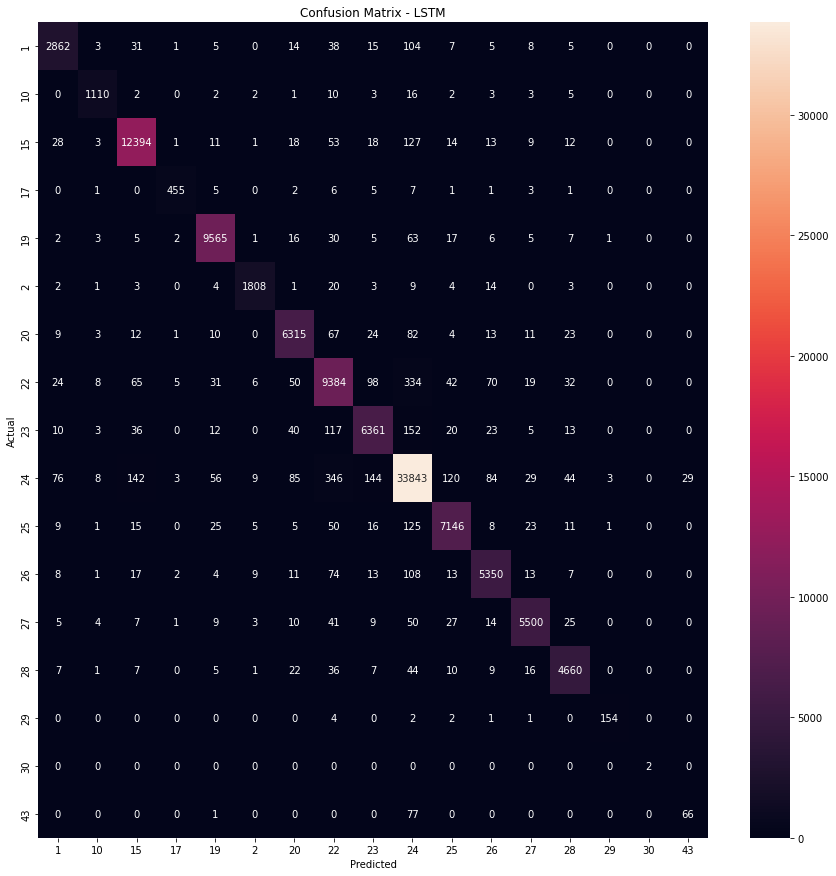

In [18]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=list(classes), yticklabels=list(classes))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - LSTM')
plt.show()

In [19]:
y_probas.shape

(111511, 44)

In [20]:
# skplt.metrics.plot_precision_recall_curve(y_test, y_probas)
# plt.title('Precision-Recall Curve - LSTM')
# plt.show()

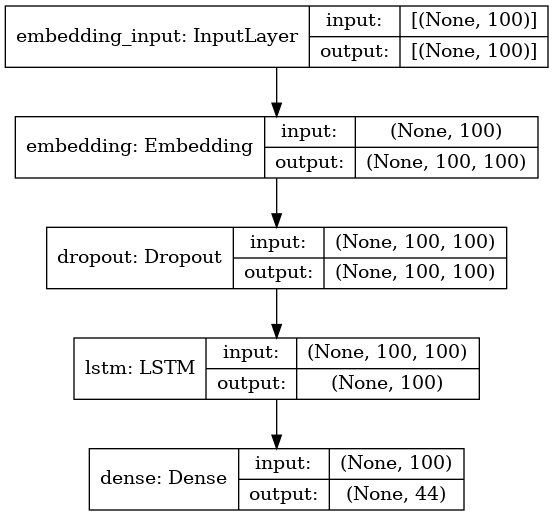

In [21]:
from keras.utils.vis_utils import plot_model
plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [22]:
import pandas as pd
import numpy as np
import string
import operator
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import os
import re
import pickle
printable=set(string.printable)
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
max_length=100
len_words=15642

def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"haven't", "will not", phrase)
    phrase = re.sub(r"wasn\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def create_model():
    global model
    model=Sequential()
    model.add(Embedding(len_words,100,input_length=max_length))
    model.add(Dropout(0.2))
    model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
    model.add(Dense(30,activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

def clean_title(title):
    try:
        title=title.replace(',','')
        title = ''.join(filter(lambda x: x in printable, title))
        title = re.sub(r"http\S+", "", title)
        title = re.sub("\S*\d\S*", "", title).strip()
        title = re.sub('[^A-Za-z]+', ' ', title)
        title = ' '.join(e.lower() for e in title.split())
        title = decontracted(title)
        return title.strip()
    except:
        return title

def load_resources():
    global tokenizer
    global model
    model.load_weights('../input/load-models/YTlstm.h5')
    with open('../input/load-models/tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

def shape_title(title):
    title=clean_title(title)
    title=tokenizer.texts_to_sequences(title)
    title=pad_sequences(title,maxlen=max_length)
    return title

def predictCategory(title):
    title=shape_title(np.array([title]))
    cat=model.predict(title)
    cat=np.argmax(cat, axis=1)
    return cat

In [23]:
create_model()
load_resources()


OSError: Unable to open file (unable to open file: name = '../input/load-models/YTlstm.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# s=input("enter title: ")
# cat=predictCategory(s)
# print(cat)